In [1]:
### Import the required libraries
import numpy as np
import scipy
import matplotlib.pyplot as plt
import cmocean

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

import tensorflow as tf
import tensorflow.keras as keras
from keras import metrics
import innvestigate

import os
from os.path import join
import sys

import xarray as xr
import xmitgcm
from xmitgcm import open_mdsdataset
import ecco_v4_py as ecco

import random

# See if GPUs are available
from keras import backend as K
if bool(K._get_available_gpus()):
    print("Running on GPU")
else:
    print("Running on CPU")

# Append to sys.path the absolute path to src/XAIRT
path_list = os.path.abspath('').split('/')
path_src_XAIRT = ''
for link in path_list[:-1]:
    path_src_XAIRT = path_src_XAIRT+link+'/'
sys.path.append(path_src_XAIRT+'/src')

# Now import module XAIRT
from XAIRT import *

### https://stackoverflow.com/questions/36288235/how-to-get-stable-results-with-tensorflow-setting-random-seed ###
### https://keras.io/examples/keras_recipes/reproducibility_recipes/ ###
SEED = 42
keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

tf.compat.v1.disable_eager_execution()

2024-01-31 09:33:40.676852: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-31 09:33:43.635718: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-01-31 09:33:43.639082: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-01-31 09:33:43.641433: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/rep

Running on GPU


In [2]:
### Sverdrup 
# mainDir  = '/scratch2/pillarh/eccov4r4'
# gridDir  = mainDir + '/GRID'
# thetaDir = mainDir + '/eccov4r4_nctiles_daily/THETA'

### Lonestar6
mainDir  = '/work/07665/shrey911/ls6/LRP_eccov4r4_data'
gridDir  = mainDir
thetaDir = mainDir

In [3]:
### Sverdrup  - /scratch2/shreyas/LRP_eccov4r4_data
### Lonestar6 - /work/07665/shrey911/ls6/LRP_eccov4r4_data

ds = xr.open_dataset(f'/work/07665/shrey911/ls6/LRP_eccov4r4_data/thetaSurfECCOv4r4.nc')

In [4]:
hFacC = ecco.read_llc_to_tiles(gridDir, 'hFacC.data')
hFacC_mask = hFacC > 0
hFacC_mask = hFacC_mask.astype(float)

XC = ds['XC'].data
YC = ds['YC'].data

latMask = YC > -20.0
latMask = latMask.astype(float)

maskFinal = hFacC_mask * latMask
NaNmaskFinal = np.copy(maskFinal)
NaNmaskFinal[NaNmaskFinal == 0] = np.nan

da_hFacC_mask = xr.DataArray(
    data=hFacC_mask,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds['tile'].data,
        j    = ds['j'].data,
        i    = ds['i'].data,
    ),
    attrs=dict(description="hFacC mask 2D 1 if > 0, else 0"),
)

da_latMask = xr.DataArray(
    data=latMask,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds['tile'].data,
        j    = ds['j'].data,
        i    = ds['i'].data,
    ),
    attrs=dict(description="Latitude Mask 1 if > -20, else 0"),
)

da_maskFinal = xr.DataArray(
    data=maskFinal,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds['tile'].data,
        j    = ds['j'].data,
        i    = ds['i'].data,
    ),
    attrs=dict(description="Mask 2D 1 if > 0, else 0"),
)

da_NaNmaskFinal = xr.DataArray(
    data=NaNmaskFinal,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds['tile'].data,
        j    = ds['j'].data,
        i    = ds['i'].data,
    ),
    attrs=dict(description="Mask 2D True if > 0, else NaN"),
)

wetpoints = np.nonzero(maskFinal.data)
da_wetpoints = xr.DataArray(
    data=np.asarray(wetpoints),
    dims=["wetpoints_dim", "num_wetpoints"],
    coords=dict(
        wetpoints_dim = np.arange(np.asarray(wetpoints).shape[0], dtype = int),
        num_wetpoints = np.arange(np.asarray(wetpoints).shape[1], dtype = int),
    ),
    attrs=dict(description="indices of wetpoints in the order (tile, j, i) in the three rows"),
)

ds = ds.assign(hFacC_mask   = da_hFacC_mask,
          latMask      = da_latMask,
          maskFinal    = da_maskFinal,
          NaNmaskFinal = da_NaNmaskFinal,
          wetpoints    = da_wetpoints)

load_binary_array: loading file /work/07665/shrey911/ls6/LRP_eccov4r4_data/hFacC.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4


In [5]:
def anomalize(field):
    
    leap_yr_offsets_jan_feb   = [0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7]
    leap_yr_offsets_after_feb = [1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7]

    if len(field.shape) > 1:
        seasonal_trend = np.zeros((366, field.shape[1]))
    else:
        seasonal_trend = np.zeros((366,))

    #### Calculate seasonal trend
    
    # Jan 1 - Feb 28
    for d in range(59):
        for year in range(26):
            seasonal_trend[d] += field[d+365*year+leap_yr_offsets_jan_feb[year]]
    seasonal_trend[:59] = seasonal_trend[:59] / 26.0
    
    # Feb 29 starting 1996, so year 2 in 0-indefielding
    n = 0
    for year in range(0,26,4):
        seasonal_trend[59] += field[365*year+n+59]
        n = n+1
    seasonal_trend[59] = seasonal_trend[59] / 7.0
            
    # Mar 1 - Dec 31
    for d in range(60,366):
        for year in range(26):
            seasonal_trend[d] += field[d-1+365*year+leap_yr_offsets_after_feb[year]]
    seasonal_trend[60:] = seasonal_trend[60:] / 26.0
    
    #### Deseason data
    
    # Jan 1 - Feb 28
    for d in range(59):
        for year in range(26):
            field[d+365*year+leap_yr_offsets_jan_feb[year]] = field[d+365*year+leap_yr_offsets_jan_feb[year]] \
                                                        - seasonal_trend[d]
    
    # Feb 29 starting 1996, so year 2 in 0-indexing
    n = 0
    for year in range(0,26,4):
        field[365*year+n+59] = field[365*year+n+59] - seasonal_trend[59]
        n = n+1
            
    # Mar 1 - Dec 31
    for d in range(60,366):
        for year in range(26):
            field[d-1+365*year+leap_yr_offsets_after_feb[year]] = field[d-1+365*year+leap_yr_offsets_after_feb[year]] \
                                                            - seasonal_trend[d]

    scipy.signal.detrend(field, axis=0, type='linear', bp=0, overwrite_data=True)
    field = field - np.mean(field, axis = 0)

    return field

In [6]:
X = ds['THETA'].data[:,wetpoints[0],wetpoints[1],wetpoints[2]].copy()
X = anomalize(X)
X_full = X.copy()
X = X[30:-30]

y = ds['THETA'].isel(tile = 10, j = 1, i = 43).data.copy()
y = anomalize(y)
# https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
y = np.convolve(y, np.ones(61)/61, mode='valid')
oneHotCost = np.zeros((y.shape[0], 2), dtype = int)
oneHotCost[:,0] = y >= 0.0
oneHotCost[:,1] = y <  0.0

In [7]:
da_X = xr.DataArray(
    data=X,
    dims=["time_allData", "num_wetpoints"],
    coords=dict(
        time_allData  = ds['time'].data[30:-30],
        num_wetpoints = ds['num_wetpoints'].data,
    ),
    attrs=dict(description="All data as matrix X; deseasoned, delinearized and mean removed."),
)

da_y = xr.DataArray(
    data=y,
    dims=["time_allData"],
    coords=dict(
        time_allData  = ds['time'].data[30:-30],
    ),
    attrs=dict(description="All cost function y; deseasoned, delinearized and mean removed."),
)

da_X_full = xr.DataArray(
    data=X_full,
    dims=["time", "num_wetpoints"],
    coords=dict(
        time          = ds['time'],
        num_wetpoints = ds['num_wetpoints'].data,
    ),
    attrs=dict(description="All data without accounting for conv filter as matrix X_full; deseasoned, delinearized and mean removed."),
)

da_oneHotCost = xr.DataArray(
    data=oneHotCost,
    dims=["time_allData", "NN_output_dim"],
    coords=dict(
        time_allData  = ds['time'].data[30:-30],
        NN_output_dim = np.array([0,1]),
    ),
    attrs=dict(description="All cost function as one-hot vector."),
)

ds = ds.assign(X          = da_X,
               y          = da_y,
               X_full     = da_X_full,
               oneHotCost = da_oneHotCost)

## Classification

In [8]:
def LRP(model, model_wo_softmax, X, y_true, lagSteps, lrp_methods, 
        suffix, normalizeDict, **kwargs):

    result = {}
    cost_NN = model.predict(X)
    result[f'score_{suffix}'] = model.evaluate(X, y_true, verbose=0)

    pred_NN = cost_NN.copy()
    pred_NN[:,0] = pred_NN[:,0] > 0.5
    pred_NN[:,1] = pred_NN[:,1] > 0.5

    idx_NN_pos = []
    idx_NN_neg = []

    if lagSteps >= 0:
        for i in range(len(y_true[lagSteps:,0])):
            if y_true[lagSteps+i,0] == 1 and pred_NN[i,0] == 1:
                idx_NN_pos.append(i)
            if y_true[lagSteps+i,1] == 1 and pred_NN[i,1] == 1:
                idx_NN_neg.append(i)
    else:
        for i in range(len(y_true[:lagSteps,0])):
            if y_true[i,0] == 1 and pred_NN[i-lagSteps,0] == 1:
                idx_NN_pos.append(i-lagSteps)
            if y_true[i,1] == 1 and pred_NN[i-lagSteps,1] == 1:
                idx_NN_neg.append(i-lagSteps)    

    rel = np.zeros((len(idx_NN_pos), 13, 90, 90))
    rel[:,:,:,:] = np.nan
    rel[:,wetpoints[0],wetpoints[1],wetpoints[2]] = X[idx_NN_pos]
    result[f'samples_correct_pos_{suffix}'] = rel

    rel = np.zeros((len(idx_NN_neg), 13, 90, 90))
    rel[:,:,:,:] = np.nan
    rel[:,wetpoints[0],wetpoints[1],wetpoints[2]] = X[idx_NN_neg]
    result[f'samples_correct_neg_{suffix}'] = rel
    
    for method in lrp_methods:

        title = method['title']
        
        print(f'Analyze using {title} for {suffix} data')
        
        Xplain = XAIR(model_wo_softmax, method, 'classic', X[idx_NN_pos], 
                      normalizeDict, **kwargs)
        a, _  = Xplain.quick_analyze()
        
        rel = np.zeros((a.shape[0], 13, 90, 90))
        rel[:,:,:,:] = np.nan
        rel[:,wetpoints[0],wetpoints[1],wetpoints[2]] = a
        result[method['title']+f'_pos_{suffix}'] = rel

        Xplain = XAIR(model_wo_softmax, method, 'classic', X[idx_NN_neg], 
                      normalizeDict, **kwargs)
        a, _  = Xplain.quick_analyze()
        
        rel = np.zeros((a.shape[0], 13, 90, 90))
        rel[:,:,:,:] = np.nan
        rel[:,wetpoints[0],wetpoints[1],wetpoints[2]] = a
        result[method['title']+f'_neg_{suffix}'] = rel

    return result

def quickSetup(X, y,
               test_split_frac,
               lrp_methods,
               lagSteps,
               decay_func = None,
               **NNkwargs):
    
    result = {}

    idx = int(X.shape[0]*(1-test_split_frac))
    X_train = X[:idx]
    oneHotCost_train = oneHotCost[:idx]
    X_test = X[idx:]
    oneHotCost_test = oneHotCost[idx:]

    keras.backend.clear_session()
    sgd = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
    NNkwargs['optimizer'] = sgd
    
    if lagSteps > 0:
        K = TrainFullyConnectedNN(X_train[:-lagSteps], oneHotCost_train[lagSteps:], **NNkwargs)
    elif lagSteps == 0:
        K = TrainFullyConnectedNN(X_train, oneHotCost_train, **NNkwargs)
    else:
        K = TrainFullyConnectedNN(X_train[-lagSteps:], oneHotCost_train[:lagSteps], **NNkwargs)
        
    best_model = K.quickTrain(decay_func)
    best_model_wo_softmax = innvestigate.model_wo_softmax(best_model)
                   
    result['cost_predict_NN'] = best_model.predict(X)
                   
    normalizeDict = {'bool_': True, 'kind': 'MaxAbs'}
    kwargs = {'y_ref': 0.00}

    # LRP for all data
    result_train = LRP(best_model, best_model_wo_softmax, 
                       X, oneHotCost, lagSteps, lrp_methods, 
                       suffix = 'all', normalizeDict = normalizeDict, **kwargs)
    result.update(result_train)
    
    # # LRP for training data
    # result_train = LRP(best_model, best_model_wo_softmax, 
    #                    X_train, oneHotCost_train, lagSteps, lrp_methods, 
    #                    suffix = 'train', normalizeDict = normalizeDict, **kwargs)
    # result.update(result_train)

    # # LRP for test data
    # result_test = LRP(best_model, best_model_wo_softmax, 
    #                    X_test, oneHotCost_test, lagSteps, lrp_methods, 
    #                    suffix = 'test', normalizeDict = normalizeDict, **kwargs)
    # result.update(result_test)
        
    return result

In [9]:
Layers = [{'size': X.shape[1], 'activation': None     , 'use_bias': None},
          {'size': 8         , 'activation': 'relu'   , 'use_bias': True, 
           'l1_w_reg': 0.001, 'l1_b_reg': 0.001, 'l2_w_reg': 1.0  , 'l2_b_reg': 1.0},
          {'size': 8         , 'activation': 'relu'   , 'use_bias': True, 
           'l1_w_reg': 0.0  , 'l1_b_reg': 0.0  , 'l2_w_reg': 0.001, 'l2_b_reg': 0.001},
          {'size': 2         , 'activation': 'softmax', 'use_bias': True, 
           'l1_w_reg': 0.0  , 'l1_b_reg': 0.0  , 'l2_w_reg': 0.001, 'l2_b_reg': 0.001}]

Losses = [{'kind': 'categorical_crossentropy', 'weight': 1.0}]

LRPDict_theta = {}
lagStepsList = [-60,-30,0,30,60,90,120,150,180]

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 50
    lrate = initial_lrate * drop**np.floor((1+epoch)/epochs_drop)
    return lrate

methods = [dict(name='lrp.alpha_1_beta_0', title = 'LRP-A1B0', optParams = {}),
           dict(name='lrp.alpha_1_beta_0', title = 'LRP-A1B0-W2', optParams = {'input_layer_rule':'WSquare'}),
           dict(name='lrp.alpha_1_beta_0', title = 'LRP-A1B0-B', optParams = {'input_layer_rule':'Bounded'})]

cmaps = ['RdBu_r', 'RdBu_r', 'RdBu_r']
color_ranges = [[-0.5,0.5], [-0.3,0.3], [-0.5,0.5]]

In [10]:
for i in range(len(lagStepsList)):

    print(f'Lag: {lagStepsList[i]} days, for Theta')
    
    NNkwargs = {'losses': Losses, 'metrics': [metrics.categorical_accuracy],
                'batch_size': 128, 'epochs': 500, 'validation_split': 0.2,
                'filename': f'model{lagStepsList[i]}', 'dirname': os.path.abspath(''),
                'random_nn_seed': 42}
    
    LRPDict_theta[f'LRP{lagStepsList[i]}'] = quickSetup(X, y, test_split_frac = 1.0/3.0,
                                                        lrp_methods = methods,
                                                        lagSteps = lagStepsList[i],
                                                        decay_func = step_decay,
                                                        layers = Layers, **NNkwargs)

Lag: -60 days, for Theta


2024-01-31 09:33:52.089592: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-01-31 09:33:52.091659: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-01-31 09:33:52.093625: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0
2024-01-31 09:33:52.105688: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2024-01-31 09:33:54.545972: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] Ten


Epoch 1: val_loss improved from inf to 1.45860, saving model to /home1/07665/shrey911/XAIRT/examples/model-60.h5

Epoch 2: val_loss improved from 1.45860 to 1.25144, saving model to /home1/07665/shrey911/XAIRT/examples/model-60.h5

Epoch 3: val_loss did not improve from 1.25144

Epoch 4: val_loss improved from 1.25144 to 1.23156, saving model to /home1/07665/shrey911/XAIRT/examples/model-60.h5

Epoch 5: val_loss did not improve from 1.23156

Epoch 6: val_loss did not improve from 1.23156

Epoch 7: val_loss did not improve from 1.23156

Epoch 8: val_loss improved from 1.23156 to 1.07804, saving model to /home1/07665/shrey911/XAIRT/examples/model-60.h5

Epoch 9: val_loss improved from 1.07804 to 1.03479, saving model to /home1/07665/shrey911/XAIRT/examples/model-60.h5

Epoch 10: val_loss did not improve from 1.03479

Epoch 11: val_loss did not improve from 1.03479

Epoch 12: val_loss improved from 1.03479 to 1.00888, saving model to /home1/07665/shrey911/XAIRT/examples/model-60.h5

Epoc

2024-01-31 09:36:58.212794: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-01-31 09:36:58.214886: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-01-31 09:36:58.216845: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 1.22754, saving model to /home1/07665/shrey911/XAIRT/examples/model-30.h5

Epoch 2: val_loss improved from 1.22754 to 0.98233, saving model to /home1/07665/shrey911/XAIRT/examples/model-30.h5

Epoch 3: val_loss improved from 0.98233 to 0.79597, saving model to /home1/07665/shrey911/XAIRT/examples/model-30.h5

Epoch 4: val_loss did not improve from 0.79597

Epoch 5: val_loss did not improve from 0.79597

Epoch 6: val_loss did not improve from 0.79597

Epoch 7: val_loss improved from 0.79597 to 0.77993, saving model to /home1/07665/shrey911/XAIRT/examples/model-30.h5

Epoch 8: val_loss did not improve from 0.77993

Epoch 9: val_loss improved from 0.77993 to 0.68746, saving model to /home1/07665/shrey911/XAIRT/examples/model-30.h5

Epoch 10: val_loss did not improve from 0.68746

Epoch 11: val_loss did not improve from 0.68746

Epoch 12: val_loss did not improve from 0.68746

Epoch 13: val_loss did not improve from 0.68746

Epoch 14: val_loss did no

2024-01-31 09:40:02.795524: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-01-31 09:40:02.797611: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-01-31 09:40:02.799580: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 0.83902, saving model to /home1/07665/shrey911/XAIRT/examples/model0.h5

Epoch 2: val_loss did not improve from 0.83902

Epoch 3: val_loss did not improve from 0.83902

Epoch 4: val_loss did not improve from 0.83902

Epoch 5: val_loss did not improve from 0.83902

Epoch 6: val_loss did not improve from 0.83902

Epoch 7: val_loss did not improve from 0.83902

Epoch 8: val_loss improved from 0.83902 to 0.53953, saving model to /home1/07665/shrey911/XAIRT/examples/model0.h5

Epoch 9: val_loss did not improve from 0.53953

Epoch 10: val_loss did not improve from 0.53953

Epoch 11: val_loss did not improve from 0.53953

Epoch 12: val_loss did not improve from 0.53953

Epoch 13: val_loss did not improve from 0.53953

Epoch 14: val_loss did not improve from 0.53953

Epoch 15: val_loss did not improve from 0.53953

Epoch 16: val_loss did not improve from 0.53953

Epoch 17: val_loss did not improve from 0.53953

Epoch 18: val_loss did not improve from 0.5

2024-01-31 09:43:00.688584: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-01-31 09:43:00.690677: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-01-31 09:43:00.692668: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 1.04865, saving model to /home1/07665/shrey911/XAIRT/examples/model30.h5

Epoch 2: val_loss did not improve from 1.04865

Epoch 3: val_loss did not improve from 1.04865

Epoch 4: val_loss did not improve from 1.04865

Epoch 5: val_loss improved from 1.04865 to 0.97276, saving model to /home1/07665/shrey911/XAIRT/examples/model30.h5

Epoch 6: val_loss did not improve from 0.97276

Epoch 7: val_loss did not improve from 0.97276

Epoch 8: val_loss did not improve from 0.97276

Epoch 9: val_loss did not improve from 0.97276

Epoch 10: val_loss did not improve from 0.97276

Epoch 11: val_loss did not improve from 0.97276

Epoch 12: val_loss did not improve from 0.97276

Epoch 13: val_loss did not improve from 0.97276

Epoch 14: val_loss did not improve from 0.97276

Epoch 15: val_loss did not improve from 0.97276

Epoch 16: val_loss did not improve from 0.97276

Epoch 17: val_loss improved from 0.97276 to 0.81130, saving model to /home1/07665/shrey911

2024-01-31 09:46:06.677858: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-01-31 09:46:06.679931: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-01-31 09:46:06.681918: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 1.20750, saving model to /home1/07665/shrey911/XAIRT/examples/model60.h5

Epoch 2: val_loss did not improve from 1.20750

Epoch 3: val_loss did not improve from 1.20750

Epoch 4: val_loss did not improve from 1.20750

Epoch 5: val_loss improved from 1.20750 to 1.14428, saving model to /home1/07665/shrey911/XAIRT/examples/model60.h5

Epoch 6: val_loss did not improve from 1.14428

Epoch 7: val_loss improved from 1.14428 to 1.07331, saving model to /home1/07665/shrey911/XAIRT/examples/model60.h5

Epoch 8: val_loss did not improve from 1.07331

Epoch 9: val_loss did not improve from 1.07331

Epoch 10: val_loss improved from 1.07331 to 1.04974, saving model to /home1/07665/shrey911/XAIRT/examples/model60.h5

Epoch 11: val_loss did not improve from 1.04974

Epoch 12: val_loss did not improve from 1.04974

Epoch 13: val_loss did not improve from 1.04974

Epoch 14: val_loss improved from 1.04974 to 1.02947, saving model to /home1/07665/shrey911/XAIRT/ex

2024-01-31 09:49:26.546087: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-01-31 09:49:26.548164: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-01-31 09:49:26.550143: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 1.20363, saving model to /home1/07665/shrey911/XAIRT/examples/model90.h5

Epoch 2: val_loss did not improve from 1.20363

Epoch 3: val_loss did not improve from 1.20363

Epoch 4: val_loss did not improve from 1.20363

Epoch 5: val_loss improved from 1.20363 to 1.19436, saving model to /home1/07665/shrey911/XAIRT/examples/model90.h5

Epoch 6: val_loss did not improve from 1.19436

Epoch 7: val_loss improved from 1.19436 to 1.14994, saving model to /home1/07665/shrey911/XAIRT/examples/model90.h5

Epoch 8: val_loss improved from 1.14994 to 0.97203, saving model to /home1/07665/shrey911/XAIRT/examples/model90.h5

Epoch 9: val_loss did not improve from 0.97203

Epoch 10: val_loss did not improve from 0.97203

Epoch 11: val_loss did not improve from 0.97203

Epoch 12: val_loss did not improve from 0.97203

Epoch 13: val_loss did not improve from 0.97203

Epoch 14: val_loss did not improve from 0.97203

Epoch 15: val_loss did not improve from 0.97203

E

2024-01-31 09:52:47.483424: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-01-31 09:52:47.485506: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-01-31 09:52:47.487481: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 1.26918, saving model to /home1/07665/shrey911/XAIRT/examples/model120.h5

Epoch 2: val_loss did not improve from 1.26918

Epoch 3: val_loss improved from 1.26918 to 1.24949, saving model to /home1/07665/shrey911/XAIRT/examples/model120.h5

Epoch 4: val_loss did not improve from 1.24949

Epoch 5: val_loss improved from 1.24949 to 1.07145, saving model to /home1/07665/shrey911/XAIRT/examples/model120.h5

Epoch 6: val_loss did not improve from 1.07145

Epoch 7: val_loss did not improve from 1.07145

Epoch 8: val_loss did not improve from 1.07145

Epoch 9: val_loss did not improve from 1.07145

Epoch 10: val_loss did not improve from 1.07145

Epoch 11: val_loss did not improve from 1.07145

Epoch 12: val_loss did not improve from 1.07145

Epoch 13: val_loss did not improve from 1.07145

Epoch 14: val_loss did not improve from 1.07145

Epoch 15: val_loss did not improve from 1.07145

Epoch 16: val_loss did not improve from 1.07145

Epoch 17: val_loss

2024-01-31 09:56:05.143644: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-01-31 09:56:05.145720: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-01-31 09:56:05.147680: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 1.28181, saving model to /home1/07665/shrey911/XAIRT/examples/model150.h5

Epoch 2: val_loss did not improve from 1.28181

Epoch 3: val_loss did not improve from 1.28181

Epoch 4: val_loss did not improve from 1.28181

Epoch 5: val_loss did not improve from 1.28181

Epoch 6: val_loss did not improve from 1.28181

Epoch 7: val_loss did not improve from 1.28181

Epoch 8: val_loss did not improve from 1.28181

Epoch 9: val_loss did not improve from 1.28181

Epoch 10: val_loss did not improve from 1.28181

Epoch 11: val_loss did not improve from 1.28181

Epoch 12: val_loss improved from 1.28181 to 1.17921, saving model to /home1/07665/shrey911/XAIRT/examples/model150.h5

Epoch 13: val_loss did not improve from 1.17921

Epoch 14: val_loss did not improve from 1.17921

Epoch 15: val_loss did not improve from 1.17921

Epoch 16: val_loss improved from 1.17921 to 1.12926, saving model to /home1/07665/shrey911/XAIRT/examples/model150.h5

Epoch 17: val_loss

2024-01-31 09:58:34.062786: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-01-31 09:58:34.064862: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-01-31 09:58:34.066824: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 1.07711, saving model to /home1/07665/shrey911/XAIRT/examples/model180.h5

Epoch 2: val_loss did not improve from 1.07711

Epoch 3: val_loss did not improve from 1.07711

Epoch 4: val_loss improved from 1.07711 to 0.99971, saving model to /home1/07665/shrey911/XAIRT/examples/model180.h5

Epoch 5: val_loss did not improve from 0.99971

Epoch 6: val_loss did not improve from 0.99971

Epoch 7: val_loss did not improve from 0.99971

Epoch 8: val_loss did not improve from 0.99971

Epoch 9: val_loss did not improve from 0.99971

Epoch 10: val_loss did not improve from 0.99971

Epoch 11: val_loss did not improve from 0.99971

Epoch 12: val_loss did not improve from 0.99971

Epoch 13: val_loss did not improve from 0.99971

Epoch 14: val_loss did not improve from 0.99971

Epoch 15: val_loss did not improve from 0.99971

Epoch 16: val_loss improved from 0.99971 to 0.97924, saving model to /home1/07665/shrey911/XAIRT/examples/model180.h5

Epoch 17: val_loss

In [11]:
def LRP_normalize(field):
    field[np.where(field < 0)] = 0.0
    field = np.nanmean(field, axis=0)
    field = field / np.nanmax(np.abs(field))
    return xr.DataArray(field)

# lrp_minus60_a1b0_b_pos_train_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0-B_pos_train'].copy())
# lrp_minus60_a1b0_b_neg_train_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0-B_neg_train'].copy())
# lrp_minus60_a1b0_w2_pos_train_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0-W2_pos_train'].copy())
# lrp_minus60_a1b0_w2_neg_train_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0-W2_neg_train'].copy())
# lrp_minus60_a1b0_pos_train_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0_pos_train'].copy())
# lrp_minus60_a1b0_neg_train_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0_neg_train'].copy())
# lrp_minus60_a1b0_b_pos_test_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0-B_pos_test'].copy())
# lrp_minus60_a1b0_b_neg_test_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0-B_neg_test'].copy())
# lrp_minus60_a1b0_w2_pos_test_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0-W2_pos_test'].copy())
# lrp_minus60_a1b0_w2_neg_test_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0-W2_neg_test'].copy())
# lrp_minus60_a1b0_pos_test_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0_pos_test'].copy())
# lrp_minus60_a1b0_neg_test_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0_neg_test'].copy())
lrp_minus60_a1b0_b_pos_all_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0-B_pos_all'].copy())
lrp_minus60_a1b0_b_neg_all_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0-B_neg_all'].copy())
lrp_minus60_a1b0_w2_pos_all_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0-W2_pos_all'].copy())
lrp_minus60_a1b0_w2_neg_all_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0-W2_neg_all'].copy())
lrp_minus60_a1b0_pos_all_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0_pos_all'].copy())
lrp_minus60_a1b0_neg_all_da = LRP_normalize(LRPDict_theta['LRP-60']['LRP-A1B0_neg_all'].copy())

# lrp_minus30_a1b0_b_pos_train_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0-B_pos_train'].copy())
# lrp_minus30_a1b0_b_neg_train_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0-B_neg_train'].copy())
# lrp_minus30_a1b0_w2_pos_train_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0-W2_pos_train'].copy())
# lrp_minus30_a1b0_w2_neg_train_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0-W2_neg_train'].copy())
# lrp_minus30_a1b0_pos_train_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0_pos_train'].copy())
# lrp_minus30_a1b0_neg_train_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0_neg_train'].copy())
# lrp_minus30_a1b0_b_pos_test_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0-B_pos_test'].copy())
# lrp_minus30_a1b0_b_neg_test_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0-B_neg_test'].copy())
# lrp_minus30_a1b0_w2_pos_test_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0-W2_pos_test'].copy())
# lrp_minus30_a1b0_w2_neg_test_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0-W2_neg_test'].copy())
# lrp_minus30_a1b0_pos_test_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0_pos_test'].copy())
# lrp_minus30_a1b0_neg_test_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0_neg_test'].copy())
lrp_minus30_a1b0_b_pos_all_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0-B_pos_all'].copy())
lrp_minus30_a1b0_b_neg_all_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0-B_neg_all'].copy())
lrp_minus30_a1b0_w2_pos_all_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0-W2_pos_all'].copy())
lrp_minus30_a1b0_w2_neg_all_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0-W2_neg_all'].copy())
lrp_minus30_a1b0_pos_all_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0_pos_all'].copy())
lrp_minus30_a1b0_neg_all_da = LRP_normalize(LRPDict_theta['LRP-30']['LRP-A1B0_neg_all'].copy())

# lrp_0_a1b0_b_pos_train_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0-B_pos_train'].copy())
# lrp_0_a1b0_b_neg_train_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0-B_neg_train'].copy())
# lrp_0_a1b0_w2_pos_train_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0-W2_pos_train'].copy())
# lrp_0_a1b0_w2_neg_train_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0-W2_neg_train'].copy())
# lrp_0_a1b0_pos_train_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0_pos_train'].copy())
# lrp_0_a1b0_neg_train_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0_neg_train'].copy())
# lrp_0_a1b0_b_pos_test_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0-B_pos_test'].copy())
# lrp_0_a1b0_b_neg_test_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0-B_neg_test'].copy())
# lrp_0_a1b0_w2_pos_test_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0-W2_pos_test'].copy())
# lrp_0_a1b0_w2_neg_test_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0-W2_neg_test'].copy())
# lrp_0_a1b0_pos_test_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0_pos_test'].copy())
# lrp_0_a1b0_neg_test_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0_neg_test'].copy())
lrp_0_a1b0_b_pos_all_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0-B_pos_all'].copy())
lrp_0_a1b0_b_neg_all_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0-B_neg_all'].copy())
lrp_0_a1b0_w2_pos_all_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0-W2_pos_all'].copy())
lrp_0_a1b0_w2_neg_all_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0-W2_neg_all'].copy())
lrp_0_a1b0_pos_all_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0_pos_all'].copy())
lrp_0_a1b0_neg_all_da = LRP_normalize(LRPDict_theta['LRP0']['LRP-A1B0_neg_all'].copy())

# lrp_30_a1b0_b_pos_train_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0-B_pos_train'].copy())
# lrp_30_a1b0_b_neg_train_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0-B_neg_train'].copy())
# lrp_30_a1b0_w2_pos_train_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0-W2_pos_train'].copy())
# lrp_30_a1b0_w2_neg_train_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0-W2_neg_train'].copy())
# lrp_30_a1b0_pos_train_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0_pos_train'].copy())
# lrp_30_a1b0_neg_train_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0_neg_train'].copy())
# lrp_30_a1b0_b_pos_test_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0-B_pos_test'].copy())
# lrp_30_a1b0_b_neg_test_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0-B_neg_test'].copy())
# lrp_30_a1b0_w2_pos_test_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0-W2_pos_test'].copy())
# lrp_30_a1b0_w2_neg_test_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0-W2_neg_test'].copy())
# lrp_30_a1b0_pos_test_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0_pos_test'].copy())
# lrp_30_a1b0_neg_test_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0_neg_test'].copy())
lrp_30_a1b0_b_pos_all_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0-B_pos_all'].copy())
lrp_30_a1b0_b_neg_all_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0-B_neg_all'].copy())
lrp_30_a1b0_w2_pos_all_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0-W2_pos_all'].copy())
lrp_30_a1b0_w2_neg_all_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0-W2_neg_all'].copy())
lrp_30_a1b0_pos_all_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0_pos_all'].copy())
lrp_30_a1b0_neg_all_da = LRP_normalize(LRPDict_theta['LRP30']['LRP-A1B0_neg_all'].copy())

# lrp_60_a1b0_b_pos_train_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0-B_pos_train'].copy())
# lrp_60_a1b0_b_neg_train_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0-B_neg_train'].copy())
# lrp_60_a1b0_w2_pos_train_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0-W2_pos_train'].copy())
# lrp_60_a1b0_w2_neg_train_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0-W2_neg_train'].copy())
# lrp_60_a1b0_pos_train_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0_pos_train'].copy())
# lrp_60_a1b0_neg_train_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0_neg_train'].copy())
# lrp_60_a1b0_b_pos_test_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0-B_pos_test'].copy())
# lrp_60_a1b0_b_neg_test_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0-B_neg_test'].copy())
# lrp_60_a1b0_w2_pos_test_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0-W2_pos_test'].copy())
# lrp_60_a1b0_w2_neg_test_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0-W2_neg_test'].copy())
# lrp_60_a1b0_pos_test_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0_pos_test'].copy())
# lrp_60_a1b0_neg_test_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0_neg_test'].copy())
lrp_60_a1b0_b_pos_all_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0-B_pos_all'].copy())
lrp_60_a1b0_b_neg_all_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0-B_neg_all'].copy())
lrp_60_a1b0_w2_pos_all_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0-W2_pos_all'].copy())
lrp_60_a1b0_w2_neg_all_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0-W2_neg_all'].copy())
lrp_60_a1b0_pos_all_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0_pos_all'].copy())
lrp_60_a1b0_neg_all_da = LRP_normalize(LRPDict_theta['LRP60']['LRP-A1B0_neg_all'].copy())

# lrp_90_a1b0_b_pos_train_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0-B_pos_train'].copy())
# lrp_90_a1b0_b_neg_train_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0-B_neg_train'].copy())
# lrp_90_a1b0_w2_pos_train_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0-W2_pos_train'].copy())
# lrp_90_a1b0_w2_neg_train_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0-W2_neg_train'].copy())
# lrp_90_a1b0_pos_train_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0_pos_train'].copy())
# lrp_90_a1b0_neg_train_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0_neg_train'].copy())
# lrp_90_a1b0_b_pos_test_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0-B_pos_test'].copy())
# lrp_90_a1b0_b_neg_test_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0-B_neg_test'].copy())
# lrp_90_a1b0_w2_pos_test_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0-W2_pos_test'].copy())
# lrp_90_a1b0_w2_neg_test_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0-W2_neg_test'].copy())
# lrp_90_a1b0_pos_test_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0_pos_test'].copy())
# lrp_90_a1b0_neg_test_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0_neg_test'].copy())
lrp_90_a1b0_b_pos_all_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0-B_pos_all'].copy())
lrp_90_a1b0_b_neg_all_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0-B_neg_all'].copy())
lrp_90_a1b0_w2_pos_all_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0-W2_pos_all'].copy())
lrp_90_a1b0_w2_neg_all_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0-W2_neg_all'].copy())
lrp_90_a1b0_pos_all_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0_pos_all'].copy())
lrp_90_a1b0_neg_all_da = LRP_normalize(LRPDict_theta['LRP90']['LRP-A1B0_neg_all'].copy())

# lrp_120_a1b0_b_pos_train_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0-B_pos_train'].copy())
# lrp_120_a1b0_b_neg_train_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0-B_neg_train'].copy())
# lrp_120_a1b0_w2_pos_train_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0-W2_pos_train'].copy())
# lrp_120_a1b0_w2_neg_train_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0-W2_neg_train'].copy())
# lrp_120_a1b0_pos_train_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0_pos_train'].copy())
# lrp_120_a1b0_neg_train_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0_neg_train'].copy())
# lrp_120_a1b0_b_pos_test_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0-B_pos_test'].copy())
# lrp_120_a1b0_b_neg_test_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0-B_neg_test'].copy())
# lrp_120_a1b0_w2_pos_test_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0-W2_pos_test'].copy())
# lrp_120_a1b0_w2_neg_test_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0-W2_neg_test'].copy())
# lrp_120_a1b0_pos_test_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0_pos_test'].copy())
# lrp_120_a1b0_neg_test_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0_neg_test'].copy())
lrp_120_a1b0_b_pos_all_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0-B_pos_all'].copy())
lrp_120_a1b0_b_neg_all_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0-B_neg_all'].copy())
lrp_120_a1b0_w2_pos_all_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0-W2_pos_all'].copy())
lrp_120_a1b0_w2_neg_all_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0-W2_neg_all'].copy())
lrp_120_a1b0_pos_all_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0_pos_all'].copy())
lrp_120_a1b0_neg_all_da = LRP_normalize(LRPDict_theta['LRP120']['LRP-A1B0_neg_all'].copy())

# lrp_150_a1b0_b_pos_train_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0-B_pos_train'].copy())
# lrp_150_a1b0_b_neg_train_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0-B_neg_train'].copy())
# lrp_150_a1b0_w2_pos_train_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0-W2_pos_train'].copy())
# lrp_150_a1b0_w2_neg_train_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0-W2_neg_train'].copy())
# lrp_150_a1b0_pos_train_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0_pos_train'].copy())
# lrp_150_a1b0_neg_train_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0_neg_train'].copy())
# lrp_150_a1b0_b_pos_test_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0-B_pos_test'].copy())
# lrp_150_a1b0_b_neg_test_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0-B_neg_test'].copy())
# lrp_150_a1b0_w2_pos_test_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0-W2_pos_test'].copy())
# lrp_150_a1b0_w2_neg_test_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0-W2_neg_test'].copy())
# lrp_150_a1b0_pos_test_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0_pos_test'].copy())
# lrp_150_a1b0_neg_test_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0_neg_test'].copy())
lrp_150_a1b0_b_pos_all_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0-B_pos_all'].copy())
lrp_150_a1b0_b_neg_all_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0-B_neg_all'].copy())
lrp_150_a1b0_w2_pos_all_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0-W2_pos_all'].copy())
lrp_150_a1b0_w2_neg_all_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0-W2_neg_all'].copy())
lrp_150_a1b0_pos_all_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0_pos_all'].copy())
lrp_150_a1b0_neg_all_da = LRP_normalize(LRPDict_theta['LRP150']['LRP-A1B0_neg_all'].copy())

# lrp_180_a1b0_b_pos_train_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0-B_pos_train'].copy())
# lrp_180_a1b0_b_neg_train_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0-B_neg_train'].copy())
# lrp_180_a1b0_w2_pos_train_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0-W2_pos_train'].copy())
# lrp_180_a1b0_w2_neg_train_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0-W2_neg_train'].copy())
# lrp_180_a1b0_pos_train_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0_pos_train'].copy())
# lrp_180_a1b0_neg_train_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0_neg_train'].copy())
# lrp_180_a1b0_b_pos_test_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0-B_pos_test'].copy())
# lrp_180_a1b0_b_neg_test_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0-B_neg_test'].copy())
# lrp_180_a1b0_w2_pos_test_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0-W2_pos_test'].copy())
# lrp_180_a1b0_w2_neg_test_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0-W2_neg_test'].copy())
# lrp_180_a1b0_pos_test_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0_pos_test'].copy())
# lrp_180_a1b0_neg_test_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0_neg_test'].copy())
lrp_180_a1b0_b_pos_all_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0-B_pos_all'].copy())
lrp_180_a1b0_b_neg_all_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0-B_neg_all'].copy())
lrp_180_a1b0_w2_pos_all_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0-W2_pos_all'].copy())
lrp_180_a1b0_w2_neg_all_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0-W2_neg_all'].copy())
lrp_180_a1b0_pos_all_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0_pos_all'].copy())
lrp_180_a1b0_neg_all_da = LRP_normalize(LRPDict_theta['LRP180']['LRP-A1B0_neg_all'].copy())

In [12]:
ds_lrp = xr.Dataset()

ds_lrp = ds_lrp.assign(# lrp_minus60_a1b0_b_pos_train = lrp_minus60_a1b0_b_pos_train_da,
                       # lrp_minus60_a1b0_b_neg_train = lrp_minus60_a1b0_b_neg_train_da,
                       # lrp_minus60_a1b0_w2_pos_train = lrp_minus60_a1b0_w2_pos_train_da,
                       # lrp_minus60_a1b0_w2_neg_train = lrp_minus60_a1b0_w2_neg_train_da,
                       # lrp_minus60_a1b0_pos_train = lrp_minus60_a1b0_pos_train_da,
                       # lrp_minus60_a1b0_neg_train = lrp_minus60_a1b0_neg_train_da,
                       # lrp_minus60_a1b0_b_pos_test = lrp_minus60_a1b0_b_pos_test_da,
                       # lrp_minus60_a1b0_b_neg_test = lrp_minus60_a1b0_b_neg_test_da,
                       # lrp_minus60_a1b0_w2_pos_test = lrp_minus60_a1b0_w2_pos_test_da,
                       # lrp_minus60_a1b0_w2_neg_test = lrp_minus60_a1b0_w2_neg_test_da,
                       # lrp_minus60_a1b0_pos_test = lrp_minus60_a1b0_pos_test_da,
                       # lrp_minus60_a1b0_neg_test = lrp_minus60_a1b0_neg_test_da,
                       lrp_minus60_a1b0_b_pos_all = lrp_minus60_a1b0_b_pos_all_da,
                       lrp_minus60_a1b0_b_neg_all = lrp_minus60_a1b0_b_neg_all_da,
                       lrp_minus60_a1b0_w2_pos_all = lrp_minus60_a1b0_w2_pos_all_da,
                       lrp_minus60_a1b0_w2_neg_all = lrp_minus60_a1b0_w2_neg_all_da,
                       lrp_minus60_a1b0_pos_all = lrp_minus60_a1b0_pos_all_da,
                       lrp_minus60_a1b0_neg_all = lrp_minus60_a1b0_neg_all_da)

ds_lrp = ds_lrp.assign(# lrp_minus30_a1b0_b_pos_train = lrp_minus30_a1b0_b_pos_train_da,
                       # lrp_minus30_a1b0_b_neg_train = lrp_minus30_a1b0_b_neg_train_da,
                       # lrp_minus30_a1b0_b_pos_test = lrp_minus30_a1b0_b_pos_test_da,
                       # lrp_minus30_a1b0_b_neg_test = lrp_minus30_a1b0_b_neg_test_da,
                       # lrp_minus30_a1b0_w2_pos_train = lrp_minus30_a1b0_w2_pos_train_da,
                       # lrp_minus30_a1b0_w2_neg_train = lrp_minus30_a1b0_w2_neg_train_da,
                       # lrp_minus30_a1b0_w2_pos_test = lrp_minus30_a1b0_w2_pos_test_da,
                       # lrp_minus30_a1b0_w2_neg_test = lrp_minus30_a1b0_w2_neg_test_da,
                       # lrp_minus30_a1b0_pos_train = lrp_minus30_a1b0_pos_train_da,
                       # lrp_minus30_a1b0_neg_train = lrp_minus30_a1b0_neg_train_da,
                       # lrp_minus30_a1b0_pos_test = lrp_minus30_a1b0_pos_test_da,
                       # lrp_minus30_a1b0_neg_test = lrp_minus30_a1b0_neg_test_da,
                       lrp_minus30_a1b0_b_pos_all = lrp_minus30_a1b0_b_pos_all_da,
                       lrp_minus30_a1b0_b_neg_all = lrp_minus30_a1b0_b_neg_all_da,
                       lrp_minus30_a1b0_w2_pos_all = lrp_minus30_a1b0_w2_pos_all_da,
                       lrp_minus30_a1b0_w2_neg_all = lrp_minus30_a1b0_w2_neg_all_da,
                       lrp_minus30_a1b0_pos_all = lrp_minus30_a1b0_pos_all_da,
                       lrp_minus30_a1b0_neg_all = lrp_minus30_a1b0_neg_all_da)

ds_lrp = ds_lrp.assign(# lrp_0_a1b0_b_pos_train = lrp_0_a1b0_b_pos_train_da,
                       # lrp_0_a1b0_b_neg_train = lrp_0_a1b0_b_neg_train_da,
                       # lrp_0_a1b0_b_pos_test = lrp_0_a1b0_b_pos_test_da,
                       # lrp_0_a1b0_b_neg_test = lrp_0_a1b0_b_neg_test_da,
                       # lrp_0_a1b0_w2_pos_train = lrp_0_a1b0_w2_pos_train_da,
                       # lrp_0_a1b0_w2_neg_train = lrp_0_a1b0_w2_neg_train_da,
                       # lrp_0_a1b0_w2_pos_test = lrp_0_a1b0_w2_pos_test_da,
                       # lrp_0_a1b0_w2_neg_test = lrp_0_a1b0_w2_neg_test_da,
                       # lrp_0_a1b0_pos_train = lrp_0_a1b0_pos_train_da,
                       # lrp_0_a1b0_neg_train = lrp_0_a1b0_neg_train_da,
                       # lrp_0_a1b0_pos_test = lrp_0_a1b0_pos_test_da,
                       # lrp_0_a1b0_neg_test = lrp_0_a1b0_neg_test_da,
                       lrp_0_a1b0_b_pos_all = lrp_0_a1b0_b_pos_all_da,
                       lrp_0_a1b0_b_neg_all = lrp_0_a1b0_b_neg_all_da,
                       lrp_0_a1b0_w2_pos_all = lrp_0_a1b0_w2_pos_all_da,
                       lrp_0_a1b0_w2_neg_all = lrp_0_a1b0_w2_neg_all_da,
                       lrp_0_a1b0_pos_all = lrp_0_a1b0_pos_all_da,
                       lrp_0_a1b0_neg_all = lrp_0_a1b0_neg_all_da)

ds_lrp = ds_lrp.assign(# lrp_30_a1b0_b_pos_train = lrp_30_a1b0_b_pos_train_da,
                       # lrp_30_a1b0_b_neg_train = lrp_30_a1b0_b_neg_train_da,
                       # lrp_30_a1b0_b_pos_test = lrp_30_a1b0_b_pos_test_da,
                       # lrp_30_a1b0_b_neg_test = lrp_30_a1b0_b_neg_test_da,
                       # lrp_30_a1b0_w2_pos_train = lrp_30_a1b0_w2_pos_train_da,
                       # lrp_30_a1b0_w2_neg_train = lrp_30_a1b0_w2_neg_train_da,
                       # lrp_30_a1b0_w2_pos_test = lrp_30_a1b0_w2_pos_test_da,
                       # lrp_30_a1b0_w2_neg_test = lrp_30_a1b0_w2_neg_test_da,
                       # lrp_30_a1b0_pos_train = lrp_30_a1b0_pos_train_da,
                       # lrp_30_a1b0_neg_train = lrp_30_a1b0_neg_train_da,
                       # lrp_30_a1b0_pos_test = lrp_30_a1b0_pos_test_da,
                       # lrp_30_a1b0_neg_test = lrp_30_a1b0_neg_test_da,
                       lrp_30_a1b0_b_pos_all = lrp_30_a1b0_b_pos_all_da,
                       lrp_30_a1b0_b_neg_all = lrp_30_a1b0_b_neg_all_da,
                       lrp_30_a1b0_w2_pos_all = lrp_30_a1b0_w2_pos_all_da,
                       lrp_30_a1b0_w2_neg_all = lrp_30_a1b0_w2_neg_all_da,
                       lrp_30_a1b0_pos_all = lrp_30_a1b0_pos_all_da,
                       lrp_30_a1b0_neg_all = lrp_30_a1b0_neg_all_da)

ds_lrp = ds_lrp.assign(# lrp_60_a1b0_b_pos_train = lrp_60_a1b0_b_pos_train_da,
                       # lrp_60_a1b0_b_neg_train = lrp_60_a1b0_b_neg_train_da,
                       # lrp_60_a1b0_b_pos_test = lrp_60_a1b0_b_pos_test_da,
                       # lrp_60_a1b0_b_neg_test = lrp_60_a1b0_b_neg_test_da,
                       # lrp_60_a1b0_w2_pos_train = lrp_60_a1b0_w2_pos_train_da,
                       # lrp_60_a1b0_w2_neg_train = lrp_60_a1b0_w2_neg_train_da,
                       # lrp_60_a1b0_w2_pos_test = lrp_60_a1b0_w2_pos_test_da,
                       # lrp_60_a1b0_w2_neg_test = lrp_60_a1b0_w2_neg_test_da,
                       # lrp_60_a1b0_pos_train = lrp_60_a1b0_pos_train_da,
                       # lrp_60_a1b0_neg_train = lrp_60_a1b0_neg_train_da,
                       # lrp_60_a1b0_pos_test = lrp_60_a1b0_pos_test_da,
                       # lrp_60_a1b0_neg_test = lrp_60_a1b0_neg_test_da,
                       lrp_60_a1b0_b_pos_all = lrp_60_a1b0_b_pos_all_da,
                       lrp_60_a1b0_b_neg_all = lrp_60_a1b0_b_neg_all_da,
                       lrp_60_a1b0_w2_pos_all = lrp_60_a1b0_w2_pos_all_da,
                       lrp_60_a1b0_w2_neg_all = lrp_60_a1b0_w2_neg_all_da,
                       lrp_60_a1b0_pos_all = lrp_60_a1b0_pos_all_da,
                       lrp_60_a1b0_neg_all = lrp_60_a1b0_neg_all_da)

ds_lrp = ds_lrp.assign(# lrp_90_a1b0_b_pos_train = lrp_90_a1b0_b_pos_train_da,
                       # lrp_90_a1b0_b_neg_train = lrp_90_a1b0_b_neg_train_da,
                       # lrp_90_a1b0_b_pos_test = lrp_90_a1b0_b_pos_test_da,
                       # lrp_90_a1b0_b_neg_test = lrp_90_a1b0_b_neg_test_da,
                       # lrp_90_a1b0_w2_pos_train = lrp_90_a1b0_w2_pos_train_da,
                       # lrp_90_a1b0_w2_neg_train = lrp_90_a1b0_w2_neg_train_da,
                       # lrp_90_a1b0_w2_pos_test = lrp_90_a1b0_w2_pos_test_da,
                       # lrp_90_a1b0_w2_neg_test = lrp_90_a1b0_w2_neg_test_da,
                       # lrp_90_a1b0_pos_train = lrp_90_a1b0_pos_train_da,
                       # lrp_90_a1b0_neg_train = lrp_90_a1b0_neg_train_da,
                       # lrp_90_a1b0_pos_test = lrp_90_a1b0_pos_test_da,
                       # lrp_90_a1b0_neg_test = lrp_90_a1b0_neg_test_da,
                       lrp_90_a1b0_b_pos_all = lrp_90_a1b0_b_pos_all_da,
                       lrp_90_a1b0_b_neg_all = lrp_90_a1b0_b_neg_all_da,
                       lrp_90_a1b0_w2_pos_all = lrp_90_a1b0_w2_pos_all_da,
                       lrp_90_a1b0_w2_neg_all = lrp_90_a1b0_w2_neg_all_da,
                       lrp_90_a1b0_pos_all = lrp_90_a1b0_pos_all_da,
                       lrp_90_a1b0_neg_all = lrp_90_a1b0_neg_all_da)

ds_lrp = ds_lrp.assign(# lrp_120_a1b0_b_pos_train = lrp_120_a1b0_b_pos_train_da,
                       # lrp_120_a1b0_b_neg_train = lrp_120_a1b0_b_neg_train_da,
                       # lrp_120_a1b0_b_pos_test = lrp_120_a1b0_b_pos_test_da,
                       # lrp_120_a1b0_b_neg_test = lrp_120_a1b0_b_neg_test_da,
                       # lrp_120_a1b0_w2_pos_train = lrp_120_a1b0_w2_pos_train_da,
                       # lrp_120_a1b0_w2_neg_train = lrp_120_a1b0_w2_neg_train_da,
                       # lrp_120_a1b0_w2_pos_test = lrp_120_a1b0_w2_pos_test_da,
                       # lrp_120_a1b0_w2_neg_test = lrp_120_a1b0_w2_neg_test_da,
                       # lrp_120_a1b0_pos_train = lrp_120_a1b0_pos_train_da,
                       # lrp_120_a1b0_neg_train = lrp_120_a1b0_neg_train_da,
                       # lrp_120_a1b0_pos_test = lrp_120_a1b0_pos_test_da,
                       # lrp_120_a1b0_neg_test = lrp_120_a1b0_neg_test_da,
                       lrp_120_a1b0_b_pos_all = lrp_120_a1b0_b_pos_all_da,
                       lrp_120_a1b0_b_neg_all = lrp_120_a1b0_b_neg_all_da,
                       lrp_120_a1b0_w2_pos_all = lrp_120_a1b0_w2_pos_all_da,
                       lrp_120_a1b0_w2_neg_all = lrp_120_a1b0_w2_neg_all_da,
                       lrp_120_a1b0_pos_all = lrp_120_a1b0_pos_all_da,
                       lrp_120_a1b0_neg_all = lrp_120_a1b0_neg_all_da)

ds_lrp = ds_lrp.assign(# lrp_150_a1b0_b_pos_train = lrp_150_a1b0_b_pos_train_da,
                       # lrp_150_a1b0_b_neg_train = lrp_150_a1b0_b_neg_train_da,
                       # lrp_150_a1b0_b_pos_test = lrp_150_a1b0_b_pos_test_da,
                       # lrp_150_a1b0_b_neg_test = lrp_150_a1b0_b_neg_test_da,
                       # lrp_150_a1b0_w2_pos_train = lrp_150_a1b0_w2_pos_train_da,
                       # lrp_150_a1b0_w2_neg_train = lrp_150_a1b0_w2_neg_train_da,
                       # lrp_150_a1b0_w2_pos_test = lrp_150_a1b0_w2_pos_test_da,
                       # lrp_150_a1b0_w2_neg_test = lrp_150_a1b0_w2_neg_test_da,
                       # lrp_150_a1b0_pos_train = lrp_150_a1b0_pos_train_da,
                       # lrp_150_a1b0_neg_train = lrp_150_a1b0_neg_train_da,
                       # lrp_150_a1b0_pos_test = lrp_150_a1b0_pos_test_da,
                       # lrp_150_a1b0_neg_test = lrp_150_a1b0_neg_test_da,
                       lrp_150_a1b0_b_pos_all = lrp_150_a1b0_b_pos_all_da,
                       lrp_150_a1b0_b_neg_all = lrp_150_a1b0_b_neg_all_da,
                       lrp_150_a1b0_w2_pos_all = lrp_150_a1b0_w2_pos_all_da,
                       lrp_150_a1b0_w2_neg_all = lrp_150_a1b0_w2_neg_all_da,
                       lrp_150_a1b0_pos_all = lrp_150_a1b0_pos_all_da,
                       lrp_150_a1b0_neg_all = lrp_150_a1b0_neg_all_da)

ds_lrp = ds_lrp.assign(# lrp_180_a1b0_b_pos_train = lrp_180_a1b0_b_pos_train_da,
                       # lrp_180_a1b0_b_neg_train = lrp_180_a1b0_b_neg_train_da,
                       # lrp_180_a1b0_b_pos_test = lrp_180_a1b0_b_pos_test_da,
                       # lrp_180_a1b0_b_neg_test = lrp_180_a1b0_b_neg_test_da,
                       # lrp_180_a1b0_w2_pos_train = lrp_180_a1b0_w2_pos_train_da,
                       # lrp_180_a1b0_w2_neg_train = lrp_180_a1b0_w2_neg_train_da,
                       # lrp_180_a1b0_w2_pos_test = lrp_180_a1b0_w2_pos_test_da,
                       # lrp_180_a1b0_w2_neg_test = lrp_180_a1b0_w2_neg_test_da,
                       # lrp_180_a1b0_pos_train = lrp_180_a1b0_pos_train_da,
                       # lrp_180_a1b0_neg_train = lrp_180_a1b0_neg_train_da,
                       # lrp_180_a1b0_pos_test = lrp_180_a1b0_pos_test_da,
                       # lrp_180_a1b0_neg_test = lrp_180_a1b0_neg_test_da,
                       lrp_180_a1b0_b_pos_all = lrp_180_a1b0_b_pos_all_da,
                       lrp_180_a1b0_b_neg_all = lrp_180_a1b0_b_neg_all_da,
                       lrp_180_a1b0_w2_pos_all = lrp_180_a1b0_w2_pos_all_da,
                       lrp_180_a1b0_w2_neg_all = lrp_180_a1b0_w2_neg_all_da,
                       lrp_180_a1b0_pos_all = lrp_180_a1b0_pos_all_da,
                       lrp_180_a1b0_neg_all = lrp_180_a1b0_neg_all_da)

ds_lrp.to_netcdf('LRP_output_forHelen/LRP_A1B0.nc')

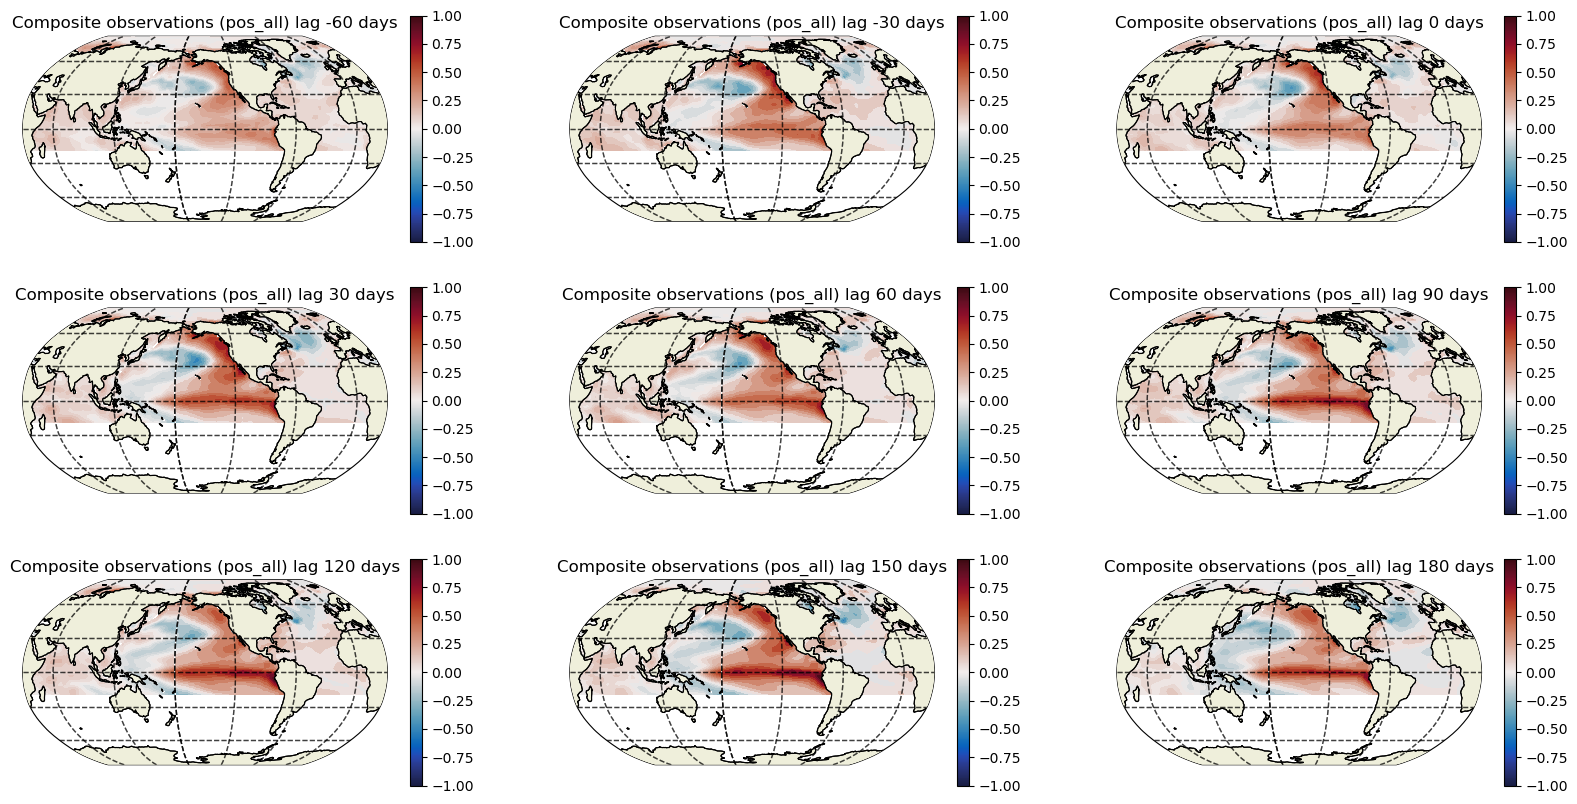

In [13]:
subplot_idx = 1
plt.rcParams["figure.figsize"] = (20,10)

for lag in lagStepsList:

    field = np.nanmean(LRPDict_theta[f'LRP{lag}']['samples_correct_pos_all'], axis=0)
    
    P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                      field,
                                      plot_type = 'contourf',
                                      show_colorbar=True, cmap=cmocean.cm.balance, 
                                      cmin = -1, cmax = 1,
                                      user_lon_0 = -150,
                                      dx=2, dy=2, projection_type = 'robin',
                                      less_output = True, subplot_grid = [3,3,subplot_idx])

    P[1].set_title(f"Composite observations (pos_all) lag {lag} days")
    subplot_idx += 1

# plt.title("Composite observations (positive_all)")
plt.show()

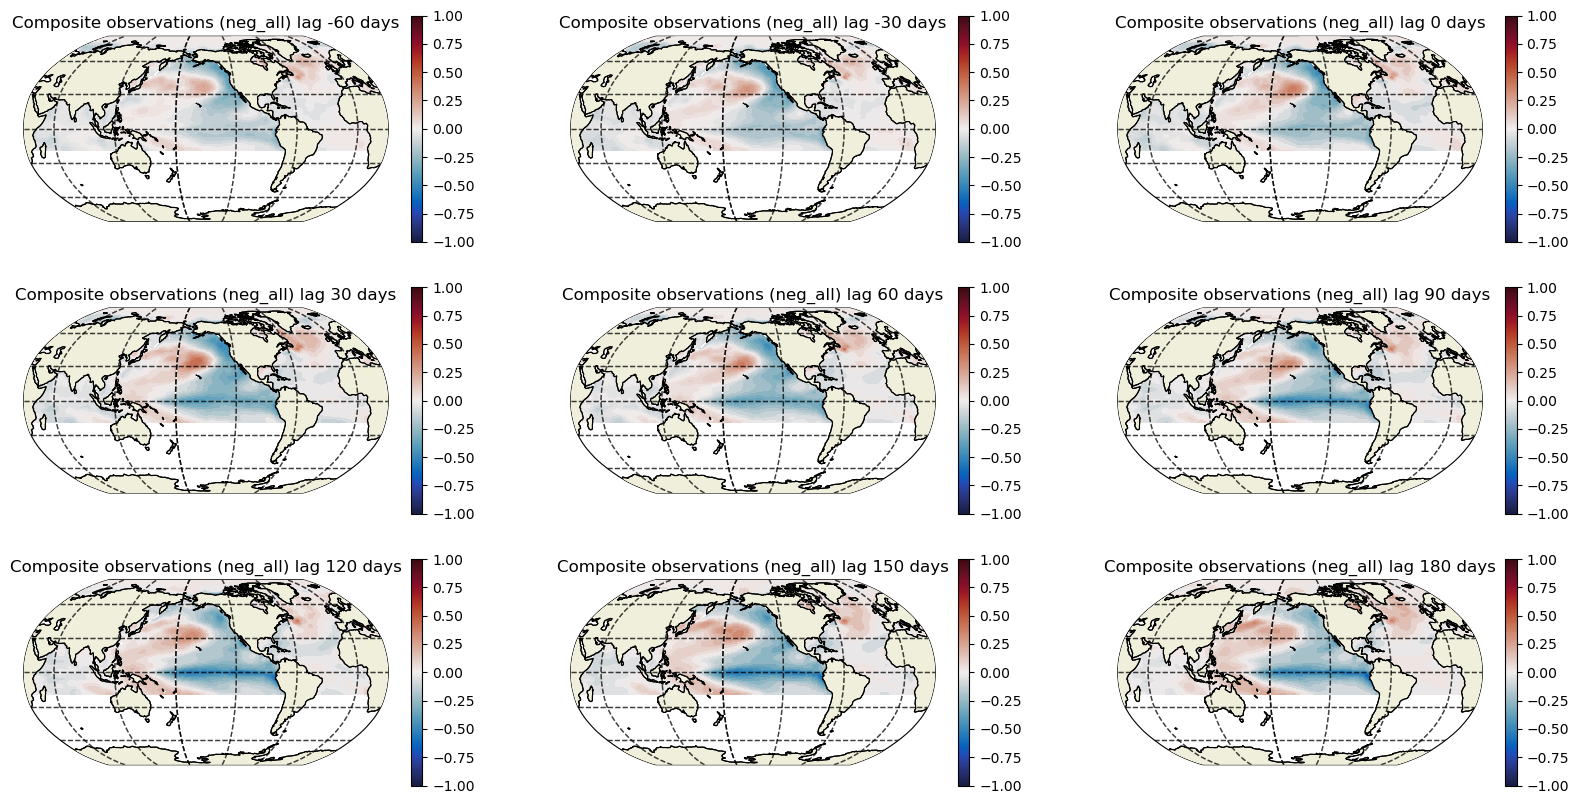

In [14]:
subplot_idx = 1
plt.rcParams["figure.figsize"] = (20,10)

for lag in lagStepsList:

    field = np.nanmean(LRPDict_theta[f'LRP{lag}']['samples_correct_neg_all'], axis=0)
    
    P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                      field,
                                      plot_type = 'contourf',
                                      show_colorbar=True, cmap=cmocean.cm.balance, 
                                      cmin = -1, cmax = 1,
                                      user_lon_0 = -150,
                                      dx=2, dy=2, projection_type = 'robin',
                                      less_output = True, subplot_grid = [3,3,subplot_idx])

    P[1].set_title(f"Composite observations (neg_all) lag {lag} days")
    subplot_idx += 1

# plt.title("Composite observations (negative_all)")
plt.show()

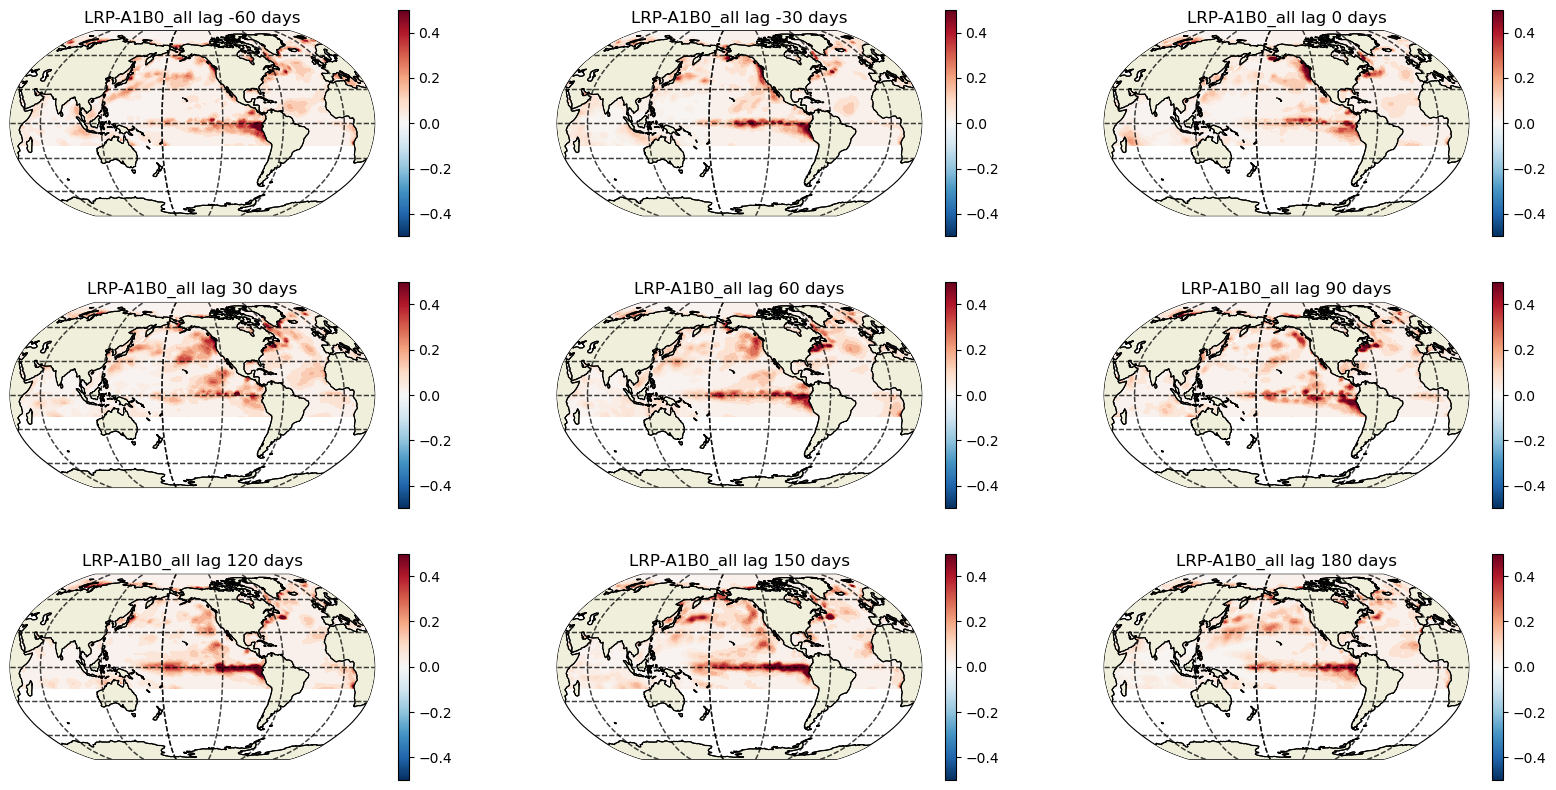

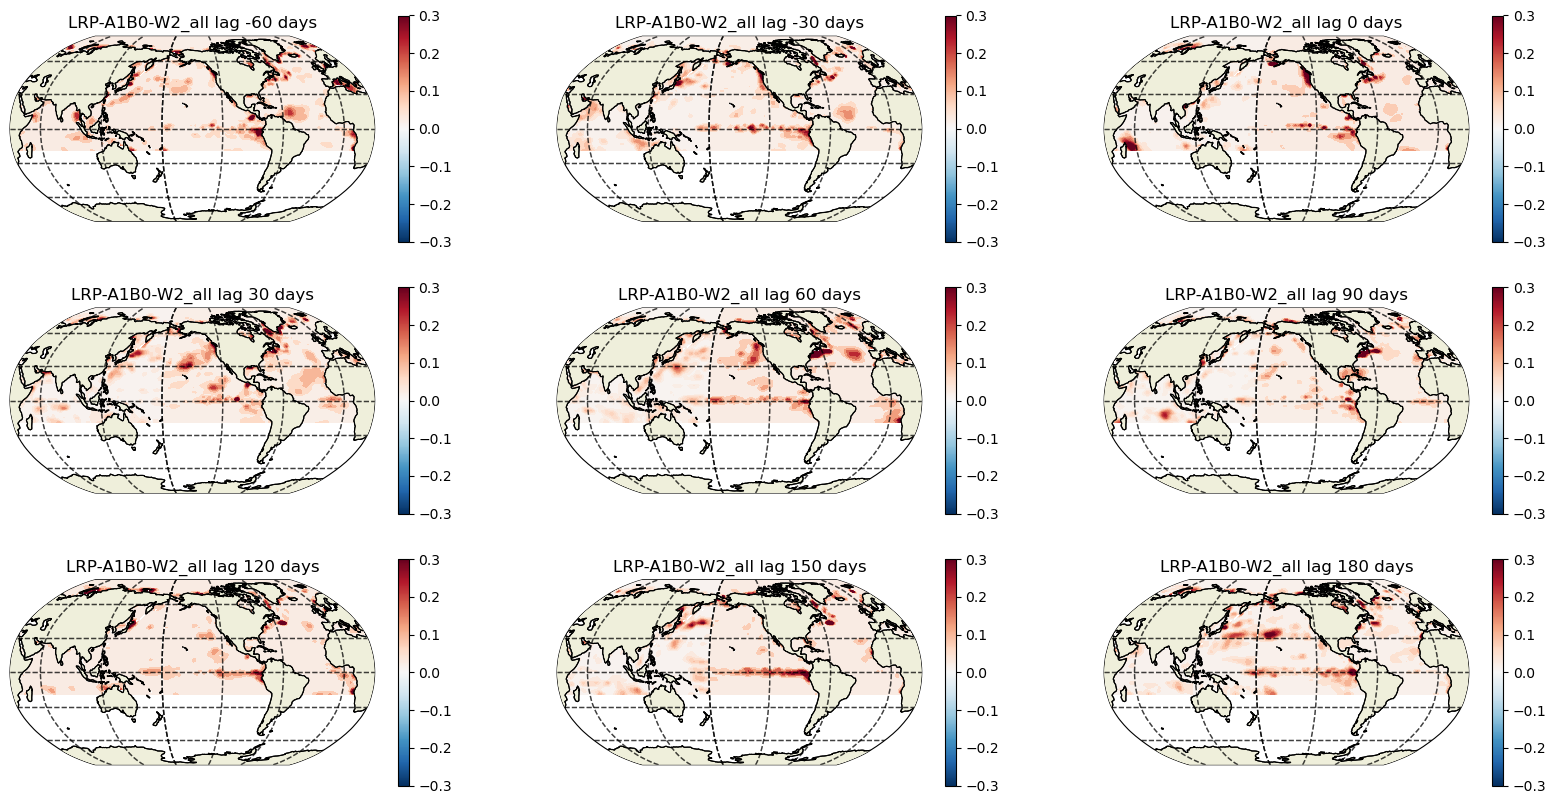

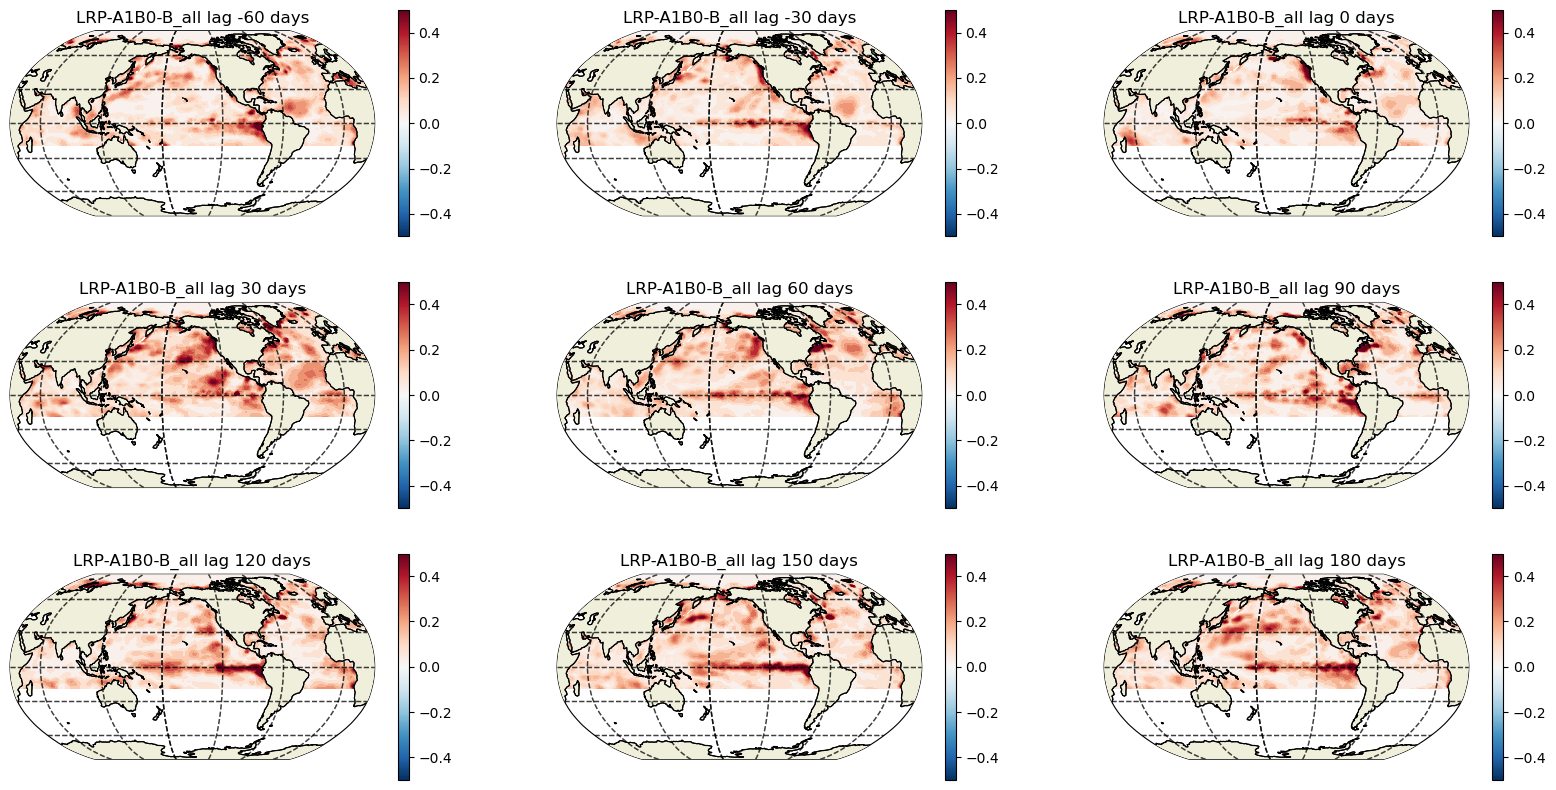

In [15]:
subplot_idx = 1
color_idx = 0

for method in methods:
    plt.rcParams["figure.figsize"] = (20,10)
    
    for lag in lagStepsList:

        field = LRPDict_theta[f'LRP{lag}'][method['title']+'_pos_all'].copy()
        field[np.where(field < 0)] = 0.0
        field = np.nanmean(field, axis=0)
        field = field / np.nanmax(np.abs(field))
        
        P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                      field,
                                      plot_type = 'contourf',
                                      show_colorbar = True, 
                                      cmap = cmaps[color_idx], 
                                      cmin = color_ranges[color_idx][0], 
                                      cmax = color_ranges[color_idx][1],
                                      user_lon_0 = -150,
                                      dx=2, dy=2, projection_type = 'robin',
                                      less_output = True, subplot_grid = [3,3,subplot_idx])

        P[1].set_title(f"{method['title']}_all lag {lag} days")
        subplot_idx += 1

    subplot_idx = 1
    color_idx += 1
    # plt.title(f"{method['title']}_all for pos QoI' w/o neg relevances")
    plt.show()

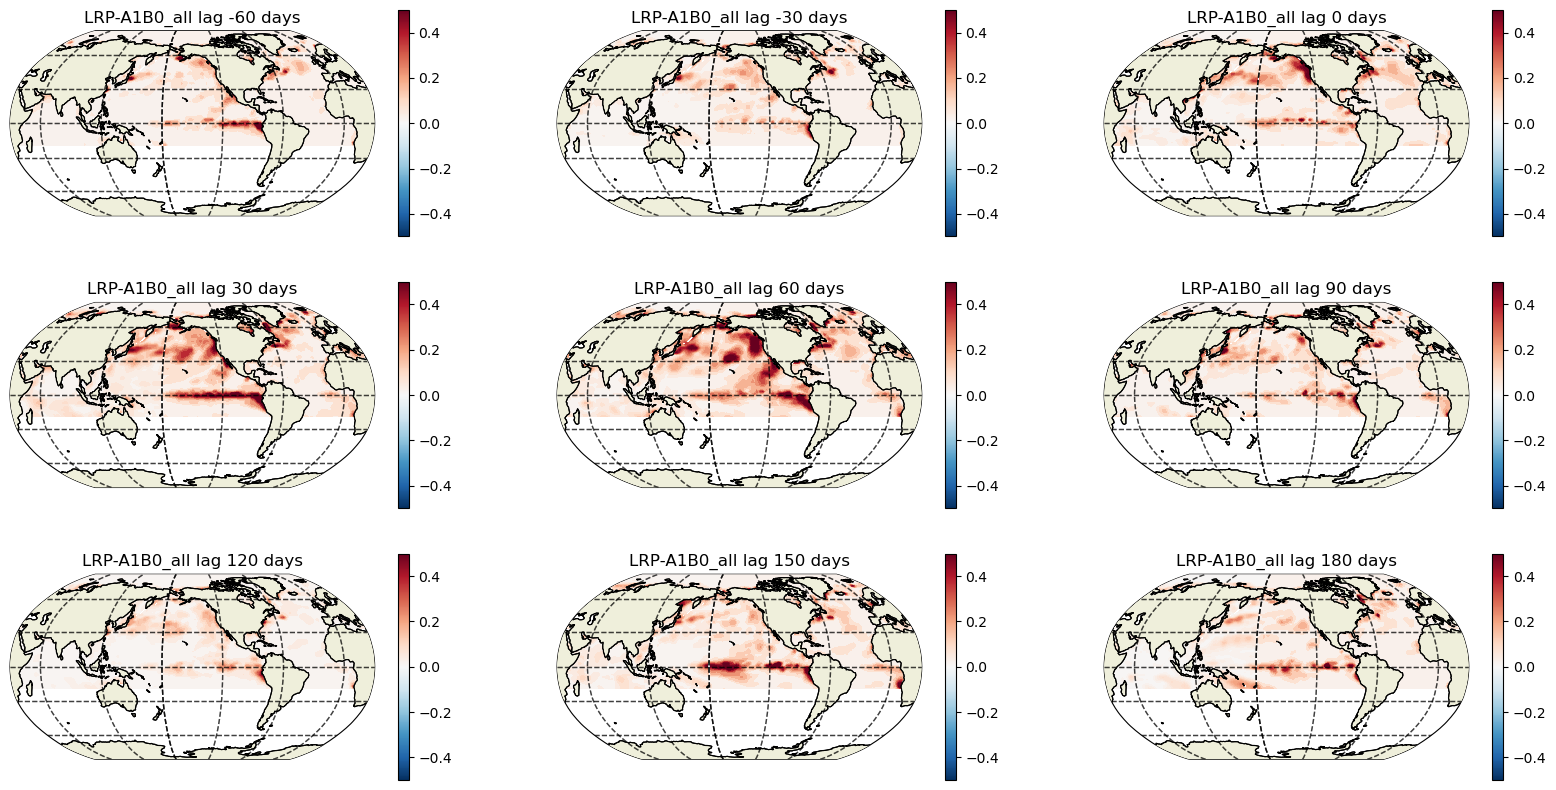

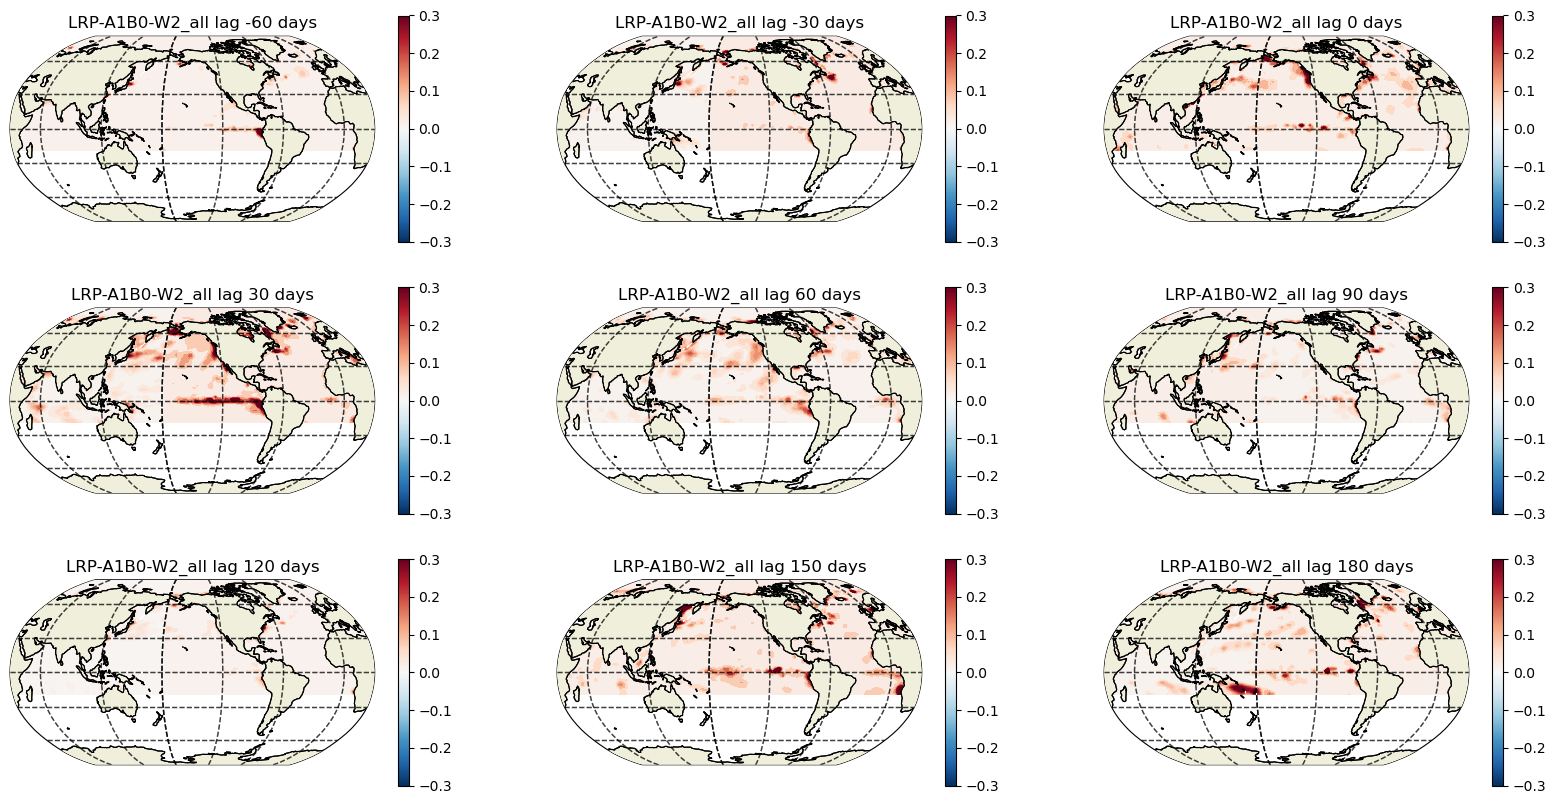

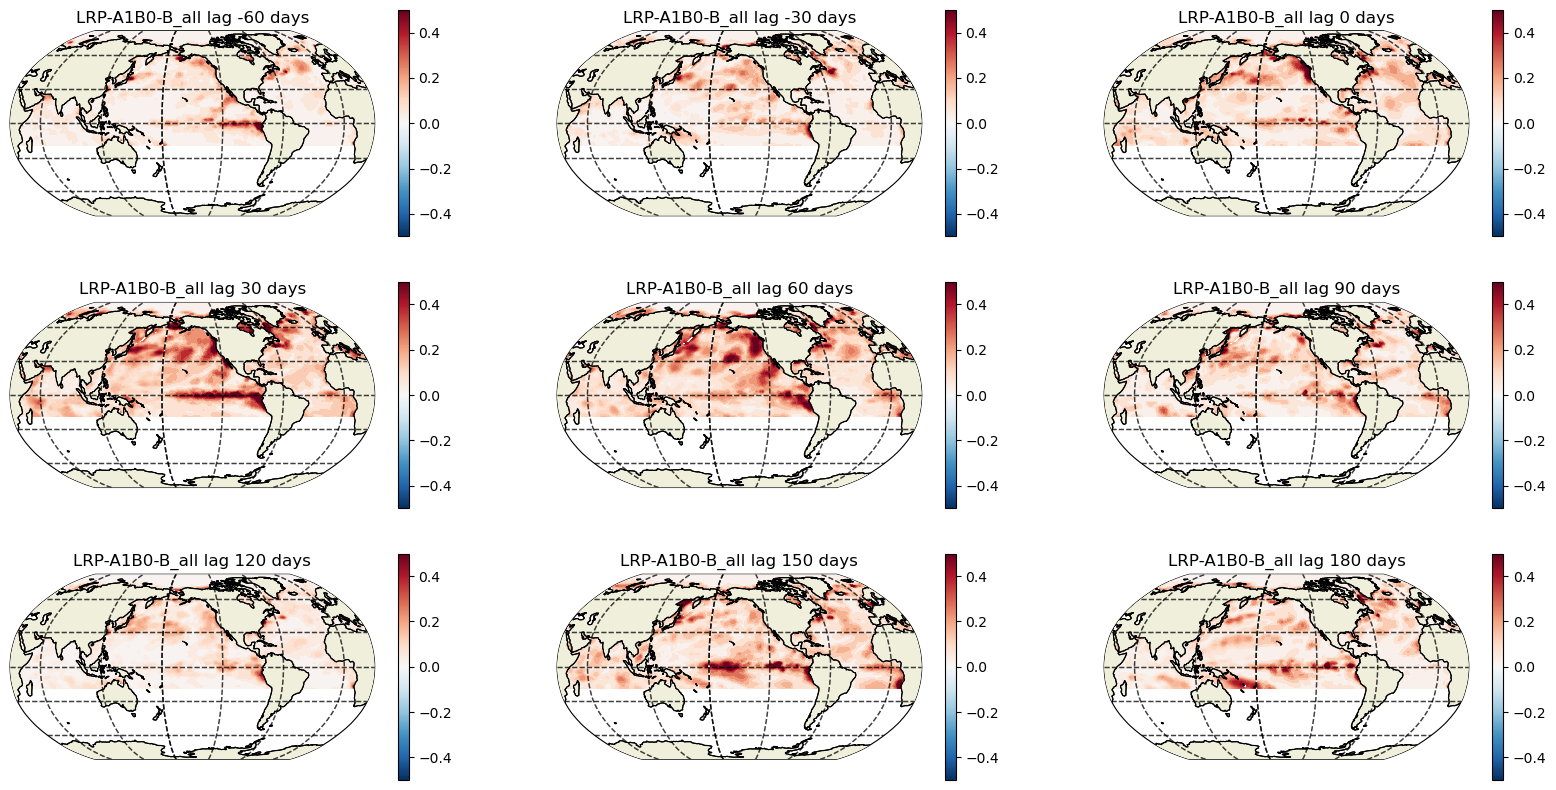

In [16]:
subplot_idx = 1
color_idx = 0

for method in methods:
    plt.rcParams["figure.figsize"] = (20,10)
    
    for lag in lagStepsList:

        field = LRPDict_theta[f'LRP{lag}'][method['title']+'_neg_all'].copy()
        field[np.where(field < 0)] = 0.0
        field = np.nanmean(field, axis=0)
        field = field / np.nanmax(np.abs(field))
        
        P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                      field,
                                      plot_type = 'contourf',
                                      show_colorbar = True,
                                      cmap = cmaps[color_idx], 
                                      cmin = color_ranges[color_idx][0], 
                                      cmax = color_ranges[color_idx][1],
                                      user_lon_0 = -150,
                                      dx=2, dy=2, projection_type = 'robin',
                                      less_output = True, subplot_grid = [3,3,subplot_idx])
        
        P[1].set_title(f"{method['title']}_all lag {lag} days")
        subplot_idx += 1
        
    subplot_idx = 1
    color_idx += 1
    # plt.title(f"{method['title']}_all for neg QoI' w/o neg relevances")
    plt.show()